In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import urllib.request
import numpy as np
import os

In [21]:
# download Wisconsin COVID data from Wisconsin DHS database and save it to data_files folder
url = 'https://opendata.arcgis.com/datasets/b913e9591eae4912b33dc5b4e88646c5_10.csv'
cwd = os.getcwd()

if os.path.exists(cwd + '//data_files') == False:
    os.mkdir(cwd + '//data_files')
    urllib.request.urlretrieve(url, cwd + '//data_files//covid.csv')
else:
    urllib.request.urlretrieve(url, cwd + '//data_files//covid.csv')

In [16]:
pd.options.display.max_columns = None
wisc = pd.read_csv('data_files//covid.csv', parse_dates=True)
wisc_counties_keep = ['LoadDttm', 'GEOID', 'GEO', 'NAME', 'NEGATIVE', 'POSITIVE', 'DEATHS']
wisc_counties = wisc[wisc['GEO']=='County']
wisc_counties = wisc_counties[wisc_counties_keep]
wisc_counties[['LoadDttm', 'temp']] = wisc_counties['LoadDttm'].str.split(expand=True)
wisc_counties = wisc_counties.drop('temp', axis=1).rename(columns={'LoadDttm':'Date'})
wisc_counties['Date'] = pd.to_datetime(wisc_counties['Date'])
wisc_counties.columns = [i.title() for i in wisc_counties.columns]
wisc_counties = wisc_counties.set_index(['Name', 'Date']).sort_index()

wisc_state = wisc[wisc['GEO']=='State']
wisc_state[['LoadDttm', 'temp']] = wisc_state['LoadDttm'].str.split(expand=True)
wisc_state = wisc_state.drop(['temp', 'OBJECTID', 'GEO', 'NAME', 'GEOID'], axis=1).rename(columns={'LoadDttm':'Date'})
wisc_state.columns = [i.title() for i in wisc_state.columns]
wisc_state['Date'] = pd.to_datetime(wisc_state['Date'])
wisc_state = wisc_state.set_index('Date')

C:\Users\Owner\Anaconda3_2\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


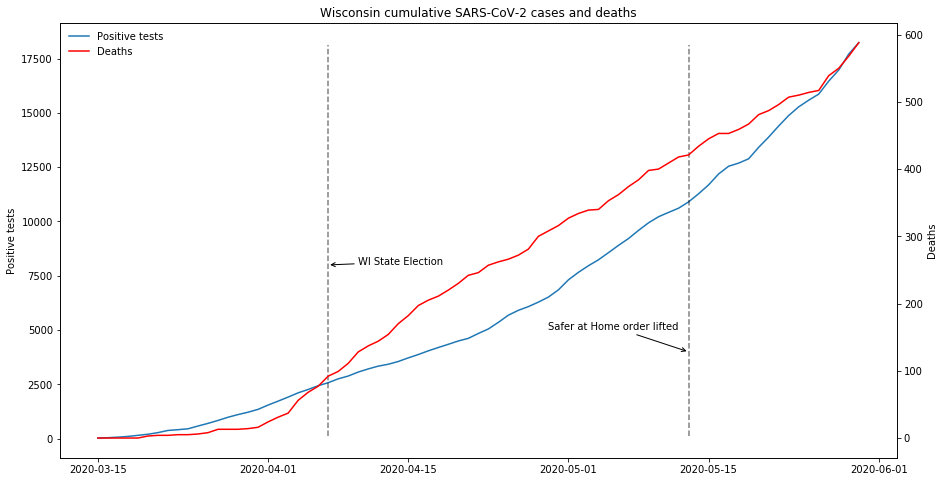

In [4]:
fig, ax = plt.subplots(figsize=[15,8])

ln1 = ax.plot(wisc_state.index, wisc_state['Positive'], label='Positive tests')
ax.axvline(x='2020/04/07', ymin=0.05, ymax=0.95,ls='--', c='black', alpha=0.5)
ax.axvline(x='2020/05/13', ymin=0.05, ymax=0.95, ls='--', c='black', alpha=0.5)
ax.set_ylabel('Positive tests')
ax.set_title('Wisconsin cumulative SARS-CoV-2 cases and deaths')
plt.annotate('WI State Election', ['2020-04-07', 8000], xytext=['2020-04-10', 8000], arrowprops=dict(arrowstyle='->'))
plt.annotate('Safer at Home order lifted', ['2020-05-13', 4000], xytext=['2020-04-29', 5000], arrowprops=dict(arrowstyle='->'))

ax2 = ax.twinx()

ln2 = ax2.plot(wisc_state.index, wisc_state['Deaths'], c='red', label='Deaths')
ax2.set_ylabel('Deaths')

lns = ln1+ln2
labels = [i.get_label() for i in lns]
ax.legend(lns, labels, frameon=False)

plt.show()

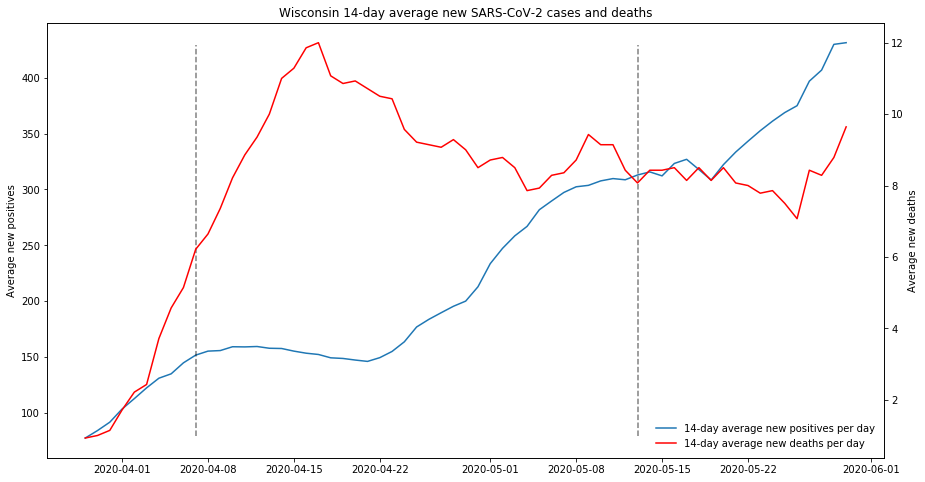

In [5]:
fig, ax = plt.subplots(figsize=[15,8])

ln1 = ax.plot(wisc_state.index, wisc_state['Pos_New'].rolling(14).mean(), 
        label='14-day average new positives per day')

ax.set_ylabel('Average new positives')
ax.set_title('Wisconsin 14-day average new SARS-CoV-2 cases and deaths')
ax.axvline(x='2020/04/07', ymin=0.05, ymax=0.95,ls='--', c='black', alpha=0.5)
ax.axvline(x='2020/05/13', ymin=0.05, ymax=0.95, ls='--', c='black', alpha=0.5)

ax2 = ax.twinx()
ln2 = ax2.plot(wisc_state.index, wisc_state['Dth_New'].rolling(14).mean(), color='red', 
         label='14-day average new deaths per day')

ax2.set_ylabel('Average new deaths')

lns = ln1+ln2
labels = [i.get_label() for i in lns]
ax.legend(lns, labels, frameon=False)

plt.show()

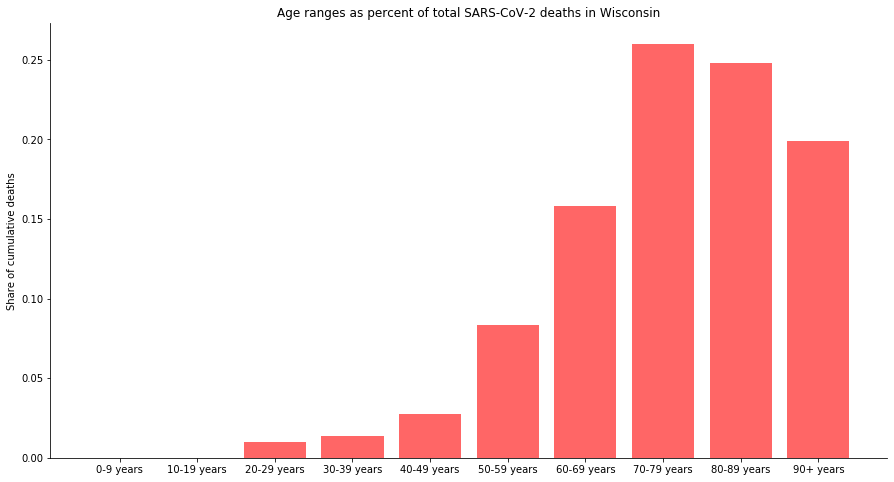

In [6]:
death_keep = ['Dths_0_9', 'Dths_10_19', 'Dths_20_29', 'Dths_30_39',
              'Dths_40_49', 'Dths_50_59', 'Dths_60_69', 'Dths_70_79',
              'Dths_80_89', 'Dths_90']

wisc_deaths = wisc_state[death_keep][-1:].transpose()
wisc_deaths.columns = ['Deaths']
wisc_deaths['Percentage'] = wisc_deaths['Deaths'] / sum(wisc_deaths['Deaths'])
wisc_deaths.index = ['0-9 years', '10-19 years', '20-29 years', '30-39 years',
                     '40-49 years', '50-59 years', '60-69 years', '70-79 years',
                     '80-89 years', '90+ years']

fig, ax = plt.subplots(figsize=[15,8])

ax.bar(wisc_deaths.index, wisc_deaths['Percentage'], color='red', alpha=0.6)
ax.set_ylabel('Share of cumulative deaths')
ax.set_title('Age ranges as percent of total SARS-CoV-2 deaths in Wisconsin')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

As expected, risk of dying from COVID-19 increases as one grows older, peaking in the 70-79 year range. I would hypothesize that people in the 80-89 and 90+ range actually have a higher risk of dying, but that there are simply significantly more people in the 70-79 range which counteracts the increased risk.

In [7]:
wisc_testing = wisc_state[['Pos_New','Neg_New', 'Test_New', 'Dth_New']]

# For some reason the value for 3-30 was entered as a negative. This function goes through the entire df and converts
# negative values to positive

def negative_cleanup(value):
    if value < 0:
        return abs(value)
    else:
        return value

wisc_testing = wisc_testing.applymap(lambda x: negative_cleanup(x))
wisc_testing['Pct_Pos'] = round((wisc_testing['Pos_New'] / wisc_testing['Test_New']), 2)
wisc_testing['Pct_Pos_14'] = wisc_testing['Pct_Pos'].rolling(14).mean()
wisc_testing_w = wisc_testing.resample('w').mean()
wisc_testing_w_sum = wisc_testing.resample('w').sum()

wisc_testing

,Pos_New,Neg_New,Test_New,Dth_New,Pct_Pos,Pct_Pos_14
Date,,,,,,
2020-03-15,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-16,15.0,191.0,206.0,0.0,0.07,NaN
2020-03-17,25.0,534.0,559.0,0.0,0.04,NaN
2020-03-18,34.0,539.0,573.0,0.0,0.06,NaN
2020-03-19,49.0,615.0,664.0,0.0,0.07,NaN
...,...,...,...,...,...,...
2020-05-26,279.0,7495.0,7774.0,3.0,0.04,0.055714
2020-05-27,599.0,9731.0,10330.0,22.0,0.06,0.055714
2020-05-28,512.0,10114.0,10626.0,11.0,0.05,0.055000


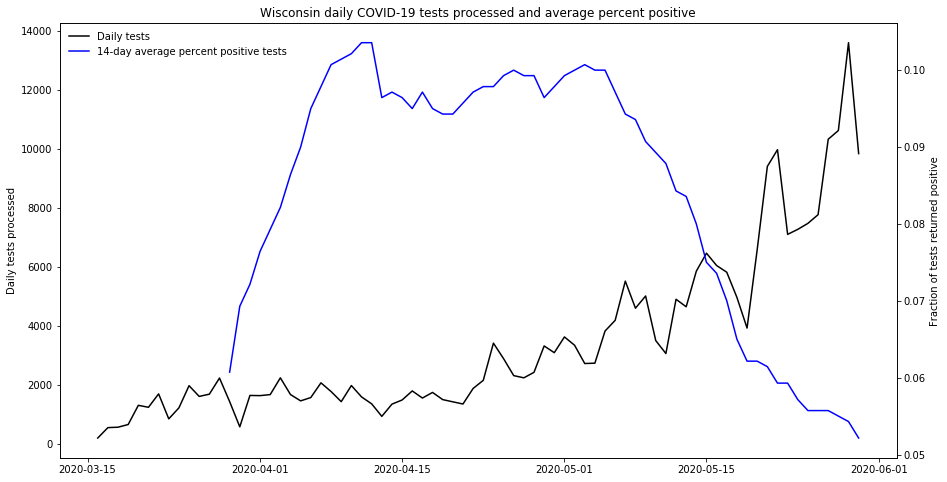

In [8]:
fig, ax = plt.subplots(figsize=[15,8])

ln1 = ax.plot(wisc_testing.index, wisc_testing['Test_New'], label='Daily tests', c='black')
ax.set_ylabel('Daily tests processed')
ax.set_title('Wisconsin daily COVID-19 tests processed and average percent positive')

ax2 = ax.twinx()
ln2 = ax2.plot(wisc_testing.index, wisc_testing['Pct_Pos_14'], label='14-day average percent positive tests', c='blue')
ax2.set_ylabel('Fraction of tests returned positive')

lns = ln1+ln2
labels = [i.get_label() for i in lns]
ax.legend(lns, labels, frameon=False)

I believe this graph shows how truly reliant we are on testing to see an honest picture of the outbreak. Early in the outbreak, only the sickest and most at-risk people were being tested for the virus. In addition to that, we weren't doing many daily tests in the first place. That, I believe, is why you see such a high plateau in 14-day average percent positive rate above. Once testing started ramping up and became available to more people, you see a rapid decline in the rate of positivity. 

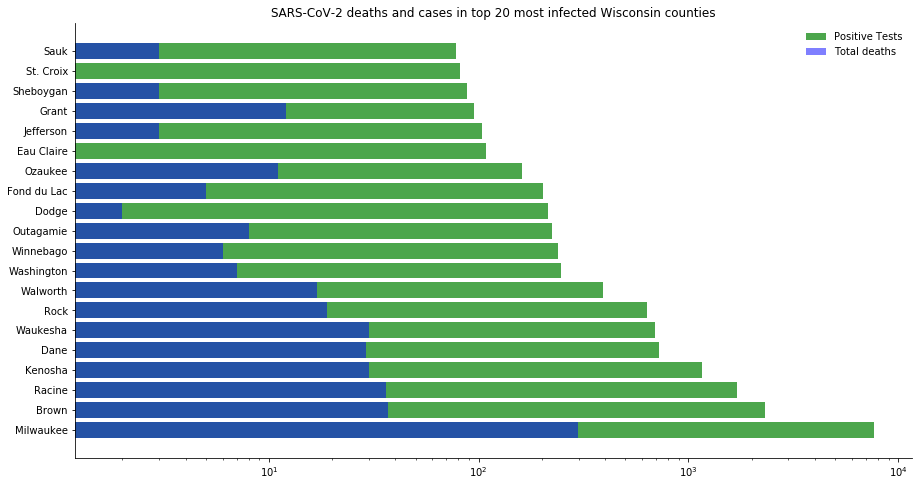

In [14]:
counties = []
counties = pd.DataFrame(counties)
counties['Name'] = np.nan
init = 0

for i in wisc_counties.index.get_level_values(0).unique():
    counties = counties.append(wisc_counties.xs(i, level=0)[-1:], sort=True)
    counties.iloc[init, 3] = i
    init += 1

counties = counties.reset_index().set_index('Name')
counties = counties.drop(['Geo', 'Geoid', 'index'], axis=1)
counties['Total'] = counties['Negative'] + counties['Positive']

counties_ordered = counties.sort_values('Positive', ascending=False)
counties_ordered = counties_ordered[:20]

fig, ax = plt.subplots(figsize=[15,8])

ax.barh(counties_ordered.index, counties_ordered['Positive'], color='green', alpha=0.7, log=True, label='Positive Tests')
ax.barh(counties_ordered.index, counties_ordered['Deaths'], color='blue', alpha=0.5, label='Total deaths')
ax.legend(frameon=False)
ax.set_title('SARS-CoV-2 deaths and cases in top 20 most infected Wisconsin counties')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [10]:
# Data on Hispanic populations is recorded through a separate survey question, so it would be hard to use it properly in
# this dataset without more information. For this reason, I am not including Hispanic populations in this data.
race_keep = ['Pos_Aian', 'Pos_Asn', 'Pos_Blk', 'Pos_Wht', 'Pos_Mltoth', 'Pos_Unk',
             'Dth_Aian', 'Dth_Asn', 'Dth_Blk', 'Dth_Wht', 'Dth_Mltoth', 'Dth_Unk']
race_names = ['American Indian or Alaskan native', 'Asian', 'Black', 'White',
              'Multiracial or other', 'Unknown' ]

wisc_race = wisc_state[race_keep]
wisc_race = wisc_race[-1:].transpose()
wisc_race.columns = ['Value']
wisc_race_pos = wisc_race[:6]
wisc_race_dth = wisc_race[6:]
wisc_race_pos['Share'] = wisc_race_pos['Value'] / sum(wisc_race_pos['Value'])
wisc_race_dth['Share'] = wisc_race_dth['Value'] / sum(wisc_race_dth['Value'])

wisc_race_dth.index = race_names
wisc_race_dth = wisc_race_dth.rename(columns={'Value':'Deaths'})

wisc_race_pos.index = race_names
wisc_race_pos = wisc_race_pos.rename(columns={'Value':'Positive tests'})

C:\Users\Owner\Anaconda3_2\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\Owner\Anaconda3_2\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


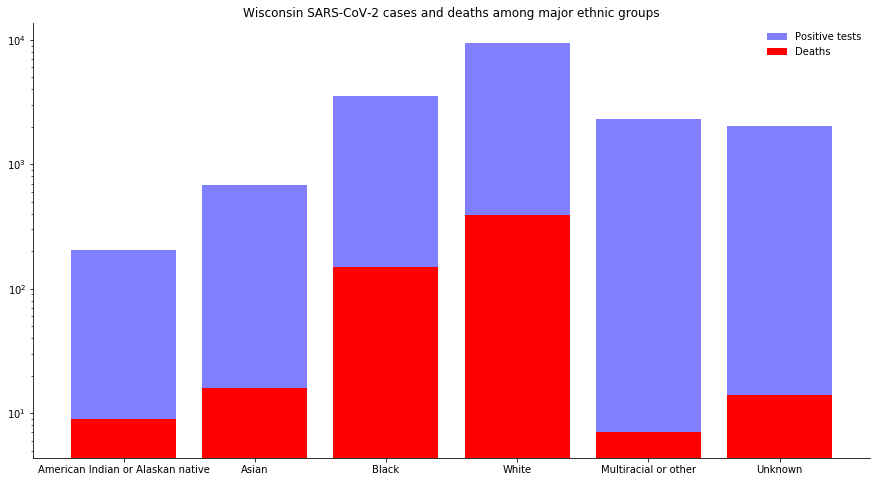

In [11]:
fig, ax = plt.subplots(figsize=[15,8])

ax.bar(wisc_race_pos.index, wisc_race_pos['Positive tests'], color='blue', log=True, alpha=0.5, label='Positive tests')
ax.bar(wisc_race_dth.index, wisc_race_dth['Deaths'], color='red', label='Deaths')

ax.set_title('Wisconsin SARS-CoV-2 cases and deaths among major ethnic groups')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon=False)

In [15]:
# I found some data on Wisconsin racial demographics from the US Census. I would like to see which groups are being
# disproportionately affected by the coronavirus.

demo = pd.read_csv('data_files//demographics.csv',skipfooter=21, usecols=['Fact','Wisconsin'], thousands=',', engine='python')

def percent_strip(x):
    return float(x.strip('%'))/100

demo = demo[11:19].set_index('Fact')
demo['Wisconsin'] = demo['Wisconsin'].map(percent_strip)
demo.index = ['White', 'Black', 'American Indian or Alaskan native', 'Asian', 'Hawaiian or Pacific Islander', 
              'Multiracial or other', 'Hispanic or Latino', 'White, not Hispanic or Latino']
demo = demo.rename(columns={'Wisconsin':'Share of population'}).sort_index()

# Dropping the rows I don't have data for in both data frames
race_differences = demo.drop(['Hawaiian or Pacific Islander', 'Hispanic or Latino', 'White, not Hispanic or Latino'], axis=0)

# Here, I'm using the assumption that all ethnic groups are equally affected by the virus to determine how many cases 
# you would expect each group to have at this point in time
race_differences['Expected cases'] = race_differences['Share of population'] * sum(wisc_race_pos['Positive tests'])
race_differences['Actual cases'] = wisc_race_pos.drop('Unknown', axis=0)['Positive tests']
race_differences['Case difference'] = race_differences['Actual cases'] - race_differences['Expected cases']

# Same process, only for deaths.
race_differences['Expected deaths'] = race_differences['Share of population'] * sum(wisc_race_dth['Deaths'])
race_differences['Actual deaths'] = wisc_race_dth.drop('Unknown', axis=0)['Deaths']
race_differences['Death difference'] = race_differences['Actual deaths'] - race_differences['Expected deaths']

race_differences

,Share of population,Expected cases,Actual cases,Case difference,Expected deaths,Actual deaths,Death difference
American Indian or Alaskan native,0.012,218.76,204.0,-14.76,7.056,9.0,1.944
Asian,0.030,546.90,680.0,133.10,17.640,16.0,-1.640
Black,0.067,1221.41,3509.0,2287.59,39.396,148.0,108.604
Multiracial or other,0.020,364.60,2309.0,1944.40,11.760,7.0,-4.760
White,0.871,15878.33,9491.0,-6387.33,512.148,394.0,-118.148


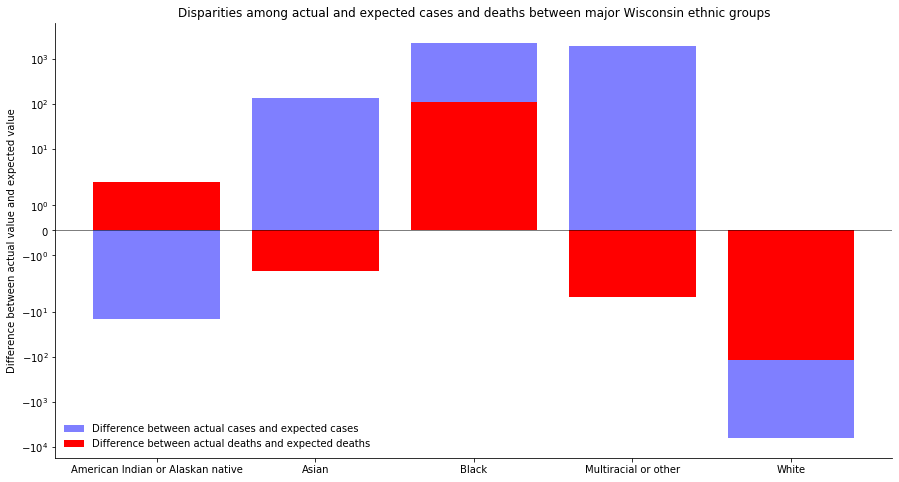

In [13]:
fig, ax = plt.subplots(figsize=[15,8])


ax.bar(race_differences.index, race_differences['Case difference'], color='blue', alpha=0.5, 
       label='Difference between actual cases and expected cases')
ax.bar(race_differences.index, race_differences['Death difference'], color='red',
       label='Difference between actual deaths and expected deaths')

ax.axhline(color='black', linewidth=0.5)
ax.set_ylabel('Difference between actual value and expected value')
ax.set_title('Disparities among actual and expected cases and deaths between major Wisconsin ethnic groups')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon=False, loc=3)

plt.gca().set_yscale('symlog')

Essentially what I did here is, based purely on each ethnicity's share of Wisconsin's population, calculated the number of cases and deaths you would expect each of the listed ethnic groups to have at this point in time. Positive values on the graph mean that the ethnic group has more cases or deaths than you would expect based on their share of Wisconsin population, and negative values mean they are experiencing fewer deaths or cases than would be expected. Based on the data, it would seem some ethnic groups are suffering from the coronavirus disproportionately more than one would expect for a population their size, namely Asians, blacks, and multiracial groups. These differences could be explained by a number of outside factors, such as population density, access to health care, and median income, among others.